#ISPR - Midterm 1

##Acciaro Gennaro Daniele


#Assignment
Perform image segmentation on all images in the dataset, using the normalized cut algorithm run on the top of superpixels rather than on raw pixels. 
For each image compute a performance metric (which one it is up to you to decide) measuring the overlap between the image segments identified by NCUT and the ground truth semantic segmentation. You do not need to show this metric for all images, rather focus on on selecting and discussing 2 examples of images that are well-segmented Vs 2 examples of images that are badly segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

# Init
These blocks take care of downloading the dataset, importing the necessary libraries and defining some utility functions.

In [1]:
#Download dataset
from google.colab import files
!rm msrc_objcategimagedatabase_v1.zip &> /dev/null
!rm rm -rf dataset &> /dev/null
!wget "http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip" &> /dev/null
!unzip "msrc_objcategimagedatabase_v1.zip" -d "dataset" &> /dev/null

folder = "dataset/MSRC_ObjCategImageDatabase_v1"
from os import listdir
from os.path import isfile, join
images = [f for f in listdir(folder) if isfile(join(folder, f))]
for single_img in images[:]:
    if not(single_img.endswith(".bmp")):
        images.remove(single_img)
    if "_GT" in single_img: # I want to save only original files
        images.remove(single_img)
images_clean = []
for single_img in images[:]:
    new_string = single_img.replace(".bmp", "")
    images_clean.append(new_string)
images = images_clean
images.sort()

In [2]:
!pip install scikit-image==0.19.2 &> /dev/null

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from skimage import io,segmentation, color
from skimage.future import graph

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
#Utilities:
def show_imgs(list_of_pics, list_of_titles=None):
    size = len(list_of_pics)
    plt.figure(figsize=(size*5, 16))

    for i, pic in enumerate(list_of_pics):
        plt.subplot(1, size, i+1)
        plt.imshow((pic))
        if(list_of_titles is not None and list_of_titles[i] is not None):
            plt.title(list_of_titles[i])
        plt.axis("off")
   
    plt.show()

def scaleTo255(img):
    """This function scales a matrix of floats (from 0 to 1) into a integer (from 0 to 255)"""
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    return img

# How did I solve the problem?
To solve this task, first, I selected a random image from the dataset for testing purposes .
After that, I defined a function to calculate the superpixels, then another function to perform the normlized cut and finally I specified a metric.
Several metrics have been studied in this notebook, each has its own pros and cons - all described in the Metric section.

At the end, there is a segmentation analysis on 4 images: 2 are well segmented and 2 are badly segmented.

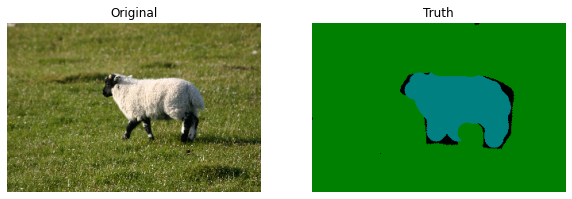

In [5]:
file_selected = "1_29_s"
img_filename = "./"+folder+"/"+file_selected+".bmp"
truth_filename = "./"+folder+"/"+file_selected+"_GT.bmp"
img   = io.imread(img_filename)
truth = io.imread(truth_filename)
show_imgs([img, truth], ["Original","Truth"])

#Superpixels

A superpixel is a group of pixels that possess the same level of intensity.
Using superpixels is essential to be able to use the normalized cut efficiently, if we try to use NCut algorithm on pixels, instead of superpixels, the time required is too much.

Superpixels are calculated using the [`segmentation.slic`](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic) function from skimage, which performs a clustering algorithm (K-Means).

But there is an important distinction between the "classical" use of a K-Means for superpixel creating and SLIC, indeed a conventional K-Means algorithm searches the entire image while SLIC performs the search in a limited region of the image; thus SLIC reduces complexity regardless of the number of superpixels.

So, in SLIC, there are two parameters:
1. **compactness**: the parameter tradeoff between color similarity of pixels
2. **segments**, the number of centroids for the KMeans algorithm

[Reference](https://core.ac.uk/download/pdf/147983593.pdf)


In [6]:
def get_super_pixels(img):
    #Parameters:
    compactness = 64
    segments = 256 
    labels = segmentation.slic(img, compactness=compactness, n_segments=segments)

    """The label2rgb function translates each label into a specific color, so we can view the regions on the pixels"""
    superpixels = scaleTo255(color.label2rgb(labels, img, kind='avg'))
    
    return labels, superpixels

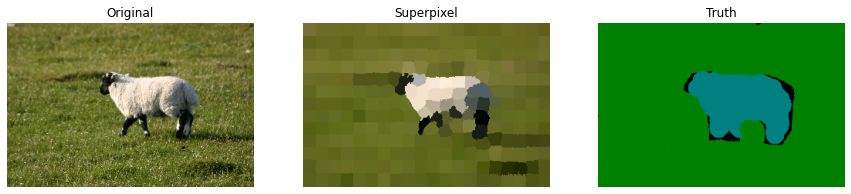

In [7]:
_, superpixel = get_super_pixels(img)
show_imgs([img, superpixel, truth], ["Original","Superpixel","Truth"])

#NCUT
An approach to image segmentation could be see the image as a graph and then partition this graph into subgraphs: this approch is called Cut.

In particular, if we use the graph notation, an image is a weighted graph $G=<V,E>$ where the vertices are the single pixels and the weights on the edges are a measure of the similarity between two pixels.

So, a cut $C=A,B$ is a partition of vertices $V$ of $G$ into a two **disjoint** subsets: $A$ and $B$.
Every cut has a cost and it's defined as the sum of the weights of the edge we need to delete to create these two subgraphs.

Here we could apply the [Minimum Cut](https://en.wikipedia.org/wiki/Minimum_cut) operation which executes cuts by applying the idea that two pixels belonging to a two different segments, needs to have a low similiraty and so we looks for the segments with a minimum cut cost.

But there is a problem in the Min Cut algorithm with outliers and isolated pixels that will always have a lower cost in the whole image, so the result of a Min-Cut may not be very useful.

For this reason we introduce the [Normalized cut](https://ieeexplore.ieee.org/document/868688), which puts as weights on the vertices no longer the similarity between two nodes but a function $assoc(A,V)$ which is the **sum** of the weights on the "frontier" of the segment A .

So the NCut minimize the following (normalized) formula:
$$Ncut(A,B) = \frac{cut(A,B)}{assoc(A,V)}\frac{cut(A,B)}{assoc(B,V)}$$


In [8]:
def normcut_segmentations(img):
    labels, superpixels = get_super_pixels(img)

    """ We need to calculate the Region Adjacency Graph (RAG)"""
    rag = graph.rag_mean_color(img, labels, mode='similarity')
    
    new_labels = graph.cut_normalized(labels, rag)

    #lc = graph.show_rag(labels, rag, img); cbar = plt.colorbar(lc) #debugging purpose
    
    """The label2rgb function translates each label into a specific color, so we can view the regions on the pixels"""
    ncuts_result = scaleTo255(color.label2rgb(new_labels, img, kind="avg", bg_label=0))

    return new_labels,ncuts_result

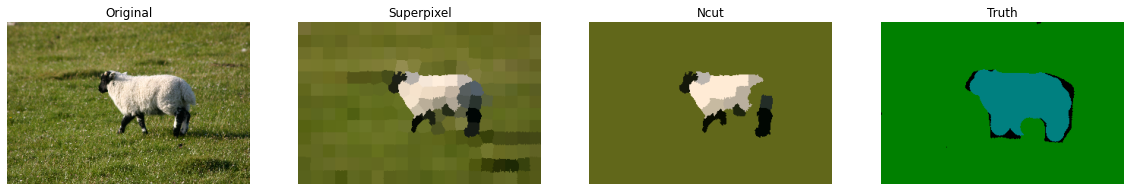

In [9]:
label,ncut = normcut_segmentations(img)
show_imgs([img, superpixel, ncut, truth], ["Original","Superpixel","Ncut","Truth"])

# Preprocessing
Now that we have defined the algorithms for the normalized cut, we need to preprocess the truth images and labels resulting from the cut.

Let's start with the truth image preprocessing: we need to translate the image (a matrix with 3 dimensions, rgb) into a matrix with a single dimension, in order to compare it with the Ncut labels; we can perform this since we know that each pixel corresponds to a particular segment.

In [10]:
""" The values from these constants have been taken from the file .html in the dataset """
VOID      = (0, np.array([0,0,0]),        "VOID")
BUILDING  = (1, np.array([128,0,0]),      "BUILDING")
GRASS     = (2, np.array([0,128,0]),      "GRASS")
TREE      = (3, np.array([128,128,0]),    "TREE")
COW       = (4, np.array([0,0,128]),      "COW")
HORSE     = (5, np.array([128,0,128]),    "HORSE")
SHEEP     = (6, np.array([0,128,128]),    "SHEEP")
SKY       = (7, np.array([128,128,128]),  "SKY")
MOUNTAIN  = (8, np.array([64,0,0]),       "MOUNTAIN")
AEROPLANE = (9, np.array([192,0,0]),      "AEROPLANE")
WATER     = (10, np.array([64,128,0]),    "WATER")
FACE      = (11, np.array([192,128,0]),   "FACE")
CAR       = (12, np.array([64,0,128]),    "CAR")
BICYCLE   = (13, np.array([192,0,128]),   "BICYCLE")

object_classes = [VOID,   BUILDING,   GRASS,  TREE,     COW,
                  HORSE,  SHEEP,      SKY,    MOUNTAIN, AEROPLANE,
                  WATER,  FACE,       CAR,    BICYCLE ]

In [11]:
def getDatasetLabel(pixel):
    """ With each class I have associated an integer number {0,..,13}.
        This function returns the associated value for a given pixel, or -1 if it's not found."""
    for klass in object_classes:
      class_id = klass[0]
      class_pixel = klass[1]
      if(np.all(pixel == class_pixel)): 
        return class_id
    return -1

def flattenTruth(truth):
    """This function takes care of translating a truth image into an matrix 
       with the same height and width, but with only one dimension, 
       whose items are the classes associated with each pixel."""
       
    result = list()
    for x in truth:
      row = list()
      for y in x:
        row.append(getDatasetLabel(y))
      result.append(row)
    return result

Truth: (213, 320, 3)  | Flat truth: (213, 320)


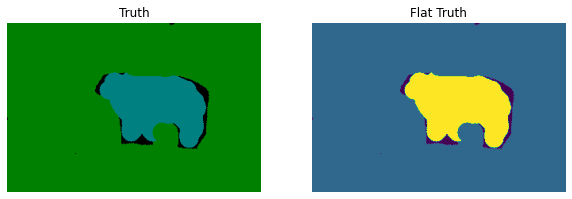

In [12]:
flatTruth = flattenTruth(truth)
print("Truth:",np.shape(truth), " | Flat truth:",np.shape(flatTruth))
show_imgs([truth, flatTruth], ["Truth",  "Flat Truth"])

Now we might think about comparing our Flat Truth with the labels computed by the NCUT algorithm since they have the same size...

In [13]:
print("NCut labels:",np.shape(label), " | Flat truth:",np.shape(flatTruth))

NCut labels: (213, 320)  | Flat truth: (213, 320)


... but if we visualize them we realize that the labels assigned to the segments do not correspond (Note the different colors for equal segments)!

We need to normalize the labels by following the same constants that are provided for the images truth

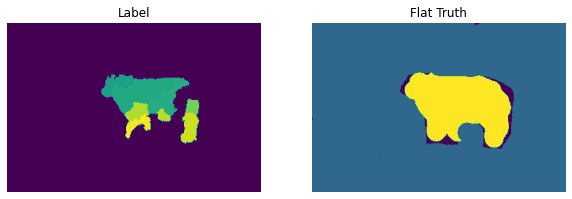

In [14]:
show_imgs([label, flatTruth], ["Label",  "Flat Truth"])

It is therefore necessary to translate the labels that are calculated by NCUT with the same indices present in a flat truth.

To do this, for each ncut label, I count how many pixels belong to each truth segment, then I take the segment with the largest count.

In [15]:
def get_set_of_pixel_for_each_label(ncut_labels):
    """For each label, this method returns the set of pixel (x,y) associated with that label"""
    labels_and_their_pixels = {}

    for label in np.unique(ncut_labels):  # Init
        labels_and_their_pixels[label] = list()

    for i, row in enumerate(ncut_labels):
        for j, label in enumerate(row):
            labels_and_their_pixels[label].append((i, j))

    return labels_and_their_pixels

#Example:
labels_and_their_pixels = get_set_of_pixel_for_each_label(label) #The input label object is given by ncut
for single_label in labels_and_their_pixels:
   print("label", single_label, " has ", len(labels_and_their_pixels[single_label]), " pixels ")

label 1  has  62587  pixels 
label 90  has  374  pixels 
label 91  has  251  pixels 
label 97  has  1991  pixels 
label 99  has  975  pixels 
label 126  has  264  pixels 
label 140  has  469  pixels 
label 142  has  186  pixels 
label 147  has  647  pixels 
label 159  has  416  pixels 


In [16]:
def normalize_label_from_truth(truth_labels, ncut_labels):
    """ This function takes care of normalizing the ncut labels using the same values used in Flat Truth.
        To do this, for each ncut label, I count how many pixels belong to each truth segment, then I take the segment with the largest count.
    """

    ncut_labels_result = np.copy(ncut_labels)

    """Map of label: for each label there is the set of pixel (x,y) associated with that label"""
    labels_and_their_pixels = get_set_of_pixel_for_each_label(ncut_labels)

    right_segment = {}

    """ In order to normalize a label found by ncut with a label in the truth image, 
            I check for each pixel of the label what is its true label, 
            after which I take the segment that maximizes the number of pixels.
    """
    for label in labels_and_their_pixels:
        pixel_associated = labels_and_their_pixels[label]

        """ Counting map  """
        count_segments = {}
        for truth_label in np.unique(truth_labels): #Init
            count_segments[truth_label] = 0

        for pixel in pixel_associated:
            x = pixel[0]
            y = pixel[1]
            true_label_for_this_pixel = truth_labels[x][y]
            count_segments[true_label_for_this_pixel] += 1

        right_segment[label] = max(count_segments, key=count_segments.get)

    """ Now that we have a match between ncut label and truth label, 
            we can fix the ncut_label matrix with the correct values """
    for label in labels_and_their_pixels:
        pixel_associated = labels_and_their_pixels[label]

        right_label = right_segment[label]
        for x,y in pixel_associated:
           ncut_labels_result[x][y] = right_label
    return ncut_labels_result

NCut labels: (213, 320)  | Flat truth: (213, 320)


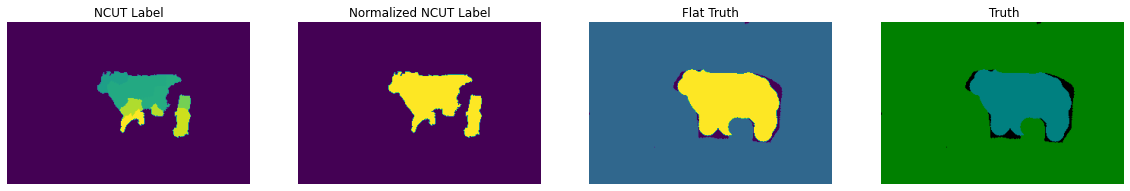

In [17]:
normalized_label = normalize_label_from_truth(truth_labels = flatTruth, 
                                                   ncut_labels = label)
print("NCut labels:",np.shape(normalized_label), " | Flat truth:",np.shape(flatTruth))
show_imgs([label,normalized_label, flatTruth, truth], ["NCUT Label", "Normalized NCUT Label", "Flat Truth"," Truth"])

# Putting all together


In [18]:
def apply_ncut(file_selected):
  img_filename = "./"+folder+"/"+file_selected+".bmp"
  truth_filename = "./"+folder+"/"+file_selected+"_GT.bmp"
  img   = io.imread(img_filename)
  truth = io.imread(truth_filename)
  _,superpixel = get_super_pixels(img)
  label,ncut = normcut_segmentations(img)

  flatTruth = flattenTruth(truth)

  normalized_label = normalize_label_from_truth(truth_labels = flatTruth, ncut_labels = label)

  show_imgs([img,ncut,normalized_label, flatTruth, truth], ["Image","NCUT","Normalized NCUT Label", "Flat Truth"," Truth"])
  return flatTruth, normalized_label #Now we can match truth and labels

# Segmentation Analysis - Metrics definition
 There are several metrics we can use for image segmenetation, in this notebook we will look at 2 of them:
1.   Pixel Accuracy
2.   Intersection over Union (or Jaccard Index)

## Pixel Accuracy
The first and easiest metric to develop is called Pixel Accuracy. It represents the percentage of correctly classified pixels.

The main disadvantage of this technique is that if one segment is much larger than the others, we will get a very high percentage even if the two images we are comparing have no other segments in common (See 'example - 1' section below)

Because of this disadvantage, in my opinion, it is only possible to use such a metric in cases where we know a priori that the segments are well balanced (for example, applying preprocessing methods to remove the background first).

In [19]:
def pixel_accuracy(truth, prediciton):
    tot = 0
    corr = 0
    for i,row in enumerate(prediciton):
        for j,pixel in enumerate(row):
            if(truth[i][j] == prediciton[i][j]):
                corr+=1
            tot+=1
    return corr/tot

### Example 1 
Taking the **5_5_s** image as example, we can see that the background (the grass) is much more present than the cows.

In any case, however, the NCUT does not recognize the second cow, despite this using the Pixel Accuracy we have an accuracy of about 90%, although there are obviously errors in the NCUT labels.

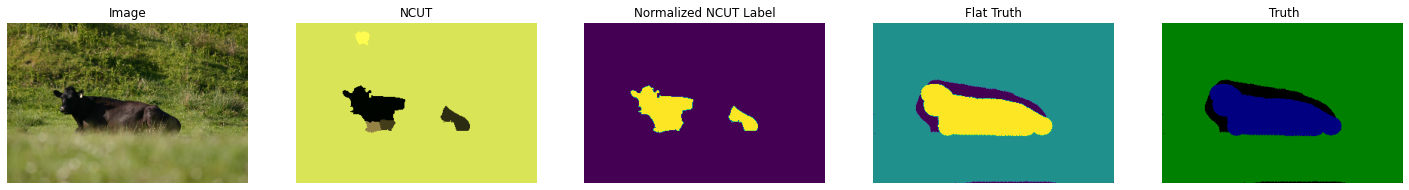

0.9005721830985915

In [20]:
truth_ex1, ncut_ex1 = apply_ncut("5_5_s")
pixel_accuracy(truth = truth_ex1,
               prediciton = ncut_ex1)

## Intersection over Union (Jaccard index)
The Jaccard Index measures the overlap of two sets. It is defined as the size of intersection over the union.

So, let A,B be two sets:

$$J(A,B) = \frac{| A ∩ B | }{| A ∪ B |}$$

So, this metric is zero if the two sets are disjoint and one if they are identical.

This is a more accurate metric than pixel accuracy if segments are unbalanced, indeed for the cows example we get only ~44.6% of accuracy.

In [21]:
from sklearn.metrics import jaccard_score
def iou_score(truth, prediction):
    jac = jaccard_score(y_true=np.asarray(truth).flatten(),
                        y_pred=np.asarray(prediction).flatten(),
                        average = "macro")
    return jac
iou_score(truth_ex1, ncut_ex1)

0.4460373867063752

# Segmentation Analysis - Metrics on the dataset
In this section I will expose some results on these 4 images:

-   6_5_s, 7_16_s
-   1_10_s, 4_19_s

The first two images are well segmented, the last two are not.

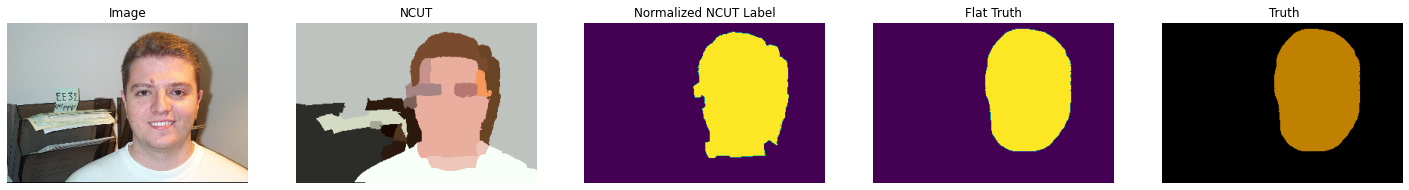

0.8943760942932889

In [22]:
ncut_sa_1,truth_sa_1 = apply_ncut("6_5_s")
iou_score(truth_sa_1, ncut_sa_1)

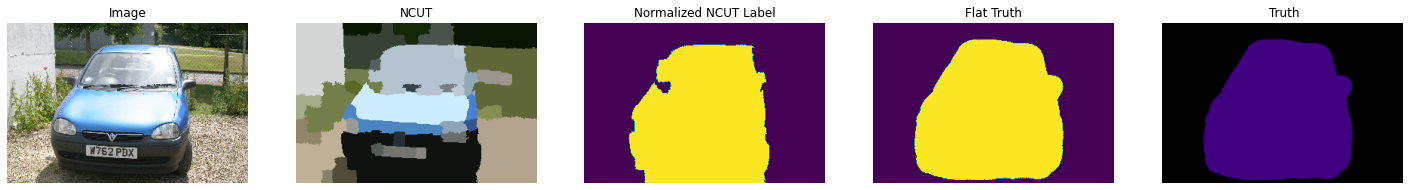

0.8891522512298441

In [23]:
ncut_sa_2,truth_sa_2 = apply_ncut("7_16_s")
iou_score(truth_sa_2, ncut_sa_2)

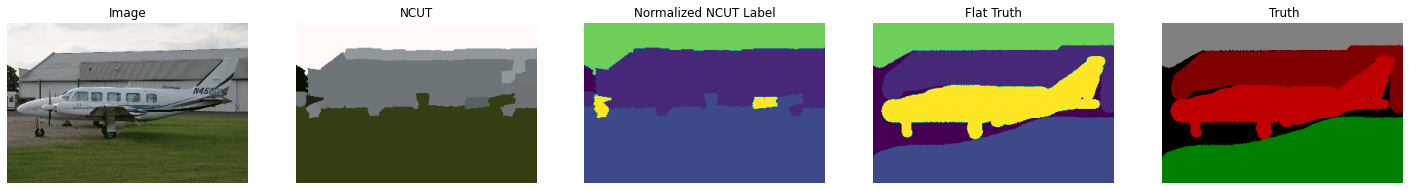

0.45602807900816344

In [24]:
ncut_sa_3,truth_sa_3 = apply_ncut("4_19_s")
iou_score(truth_sa_3, ncut_sa_3)

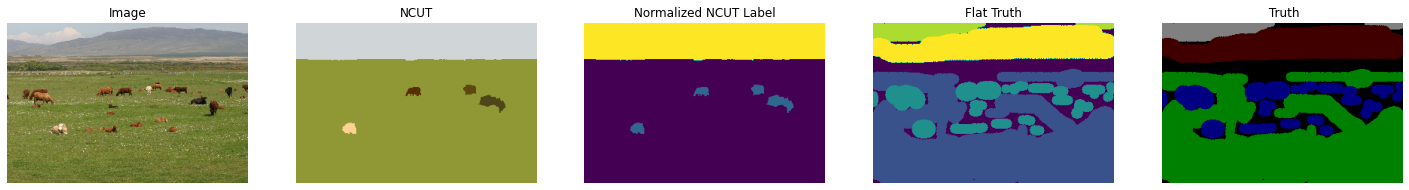

0.2980682219751401

In [25]:
ncut_sa_4,truth_sa_4 = apply_ncut("1_10_s")
iou_score(truth_sa_4, ncut_sa_4)

## Finals observations

A weak aspect to highlight is the choice of parameters for segmentation, through some empirical tests I selected those values that have returned better results but as we can see in the case of image 4_19_s those parameters are not perfect.

So a possible way to enhance the analysis could be the execution of a grid search to select the best parameters

Another weak aspect to note is the poor quality of the ground truth images in the dataset, with a more precise segmentation you can get better results.